#  Data & IA Project
### Aymene Mazouz - Yasmina Moussaoui - Toby Pollock

## Objectif du Projet
Les maladies cardiaques constituent l'une des principales causes de mortalité dans le monde. La capacité à prédire le risque de développer une maladie cardiaque à partir de données médicales est cruciale pour mettre en place des mesures préventives adaptées, améliorer les traitements, et sauver des vies. Ce projet a pour but de développer un modèle prédictif capable d'évaluer le risque qu'un patient soit atteint d'une maladie cardiaque en se basant sur ses données cliniques, et ceci avec une bonne precision.

## Description des Données
Le dataset utilisé dans ce projet, intitulé heart_disease_data.csv, contient les informations médicales de plusieurs patients.
Les attributs de ces données sont les suivants :
- **Age** : âge du patient (en années).
- **Sex** : sexe du patient (M : Homme, F : Femme).
- **ChestPainType** : type de douleur thoracique (TA : Angine typique, ATA : Angine atypique, NAP : Douleur non angineuse, ASY : Asymptomatique).
- **RestingBP** : tension artérielle au repos (en mm Hg).
- **Cholesterol** : cholestérol sérique (en mg/dl).
- **FastingBS** : glycémie à jeun (1 : si > 120 mg/dl, 0 : sinon).
- **RestingECG** : résultats de l’électrocardiogramme au repos (Normal : Normal, ST : anomalies ST-T, LVH : Hypertrophie ventriculaire gauche).
- **MaxHR** : fréquence cardiaque maximale atteinte.
- **ExerciseAngina** : angine provoquée par l’effort (Y : Oui, N : Non).
- **Oldpeak** : dépression du segment ST mesurée (valeur numérique).
- **ST_Slope** : pente du segment ST à l’effort (Up : ascendante, Flat : plate, Down :
descendante).
- **HeartDisease** : présence ou absence de maladie cardiaque (1 : Oui, 0 : Non).

In [41]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, kendalltau
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

In [42]:
# Configuration de l'affichage
plt.style.use('seaborn-v0_8-notebook')
sns.set_palette('Set2')

In [43]:
#Chargement des données
df = pd.read_csv('./data/heart_disease_data.csv')

In [44]:
#Affichage des premiéres lignes
display(df.head())

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [45]:
#Informations générales 
print("Informations sur les données :")
df.info()

print("\nStatistiques descriptives :")
display(df.describe())

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Statistiques descriptives :


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [46]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())


Valeurs manquantes :
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Variables catégorielles détectées : ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


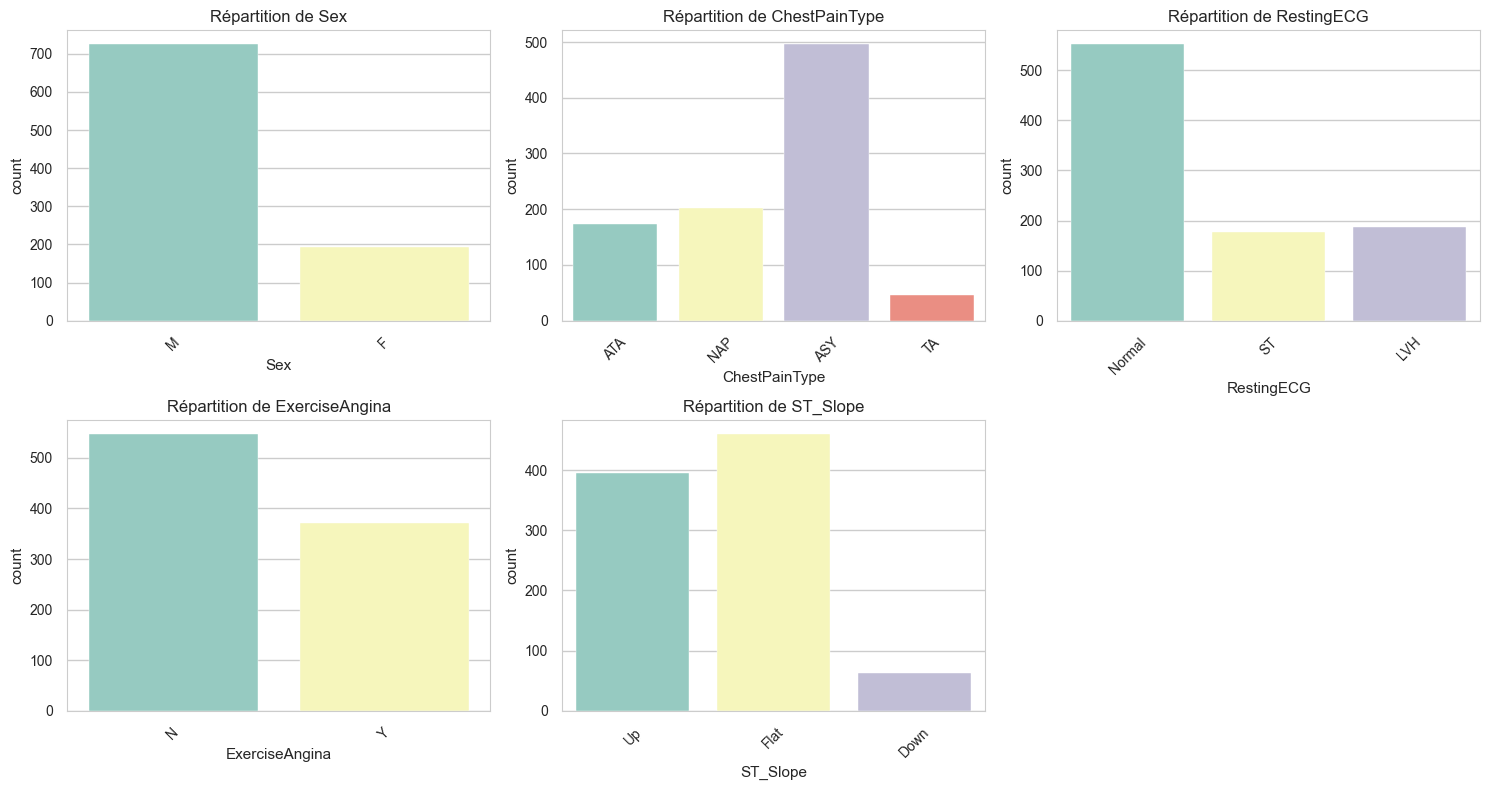

In [47]:
# Subplots pour la distribution des variables catégorielles
# Détection automatique des variables catégorielles
cat_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Variables catégorielles détectées : {cat_features}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feature in enumerate(cat_features):
    sns.countplot(data=df, x=feature, hue=feature, palette='Set3', ax=axes[idx])
    axes[idx].set_title(f"Répartition de {feature}")
    axes[idx].tick_params(axis='x', rotation=45)

# Supprimer les subplots vides (si nombre impair)
for i in range(len(cat_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

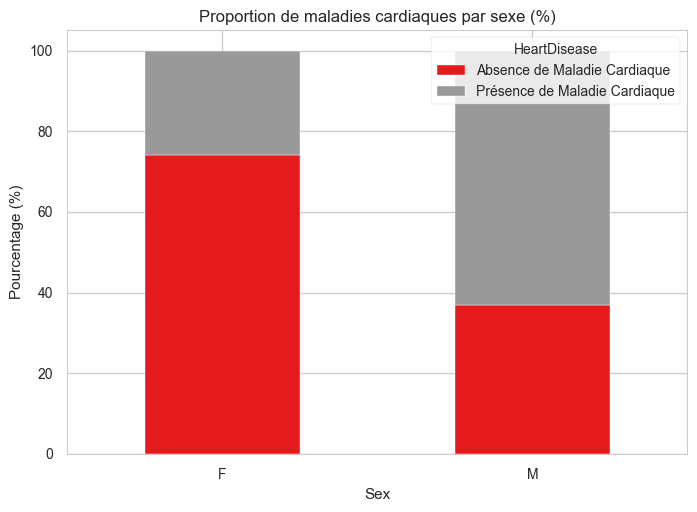

In [48]:
# Calcul des pourcentages de maladies cardiaques par sexe
proportion_df = df.groupby('Sex')['HeartDisease'].value_counts(normalize=True).unstack() * 100

# Visualisation
plt.figure(figsize=(6, 4))
proportion_df.plot(kind='bar', stacked=True, colormap='Set1')
plt.title("Proportion de maladies cardiaques par sexe (%)")
plt.ylabel("Pourcentage (%)")
plt.xticks(rotation=0)
plt.legend(["Absence de Maladie Cardiaque", "Présence de Maladie Cardiaque"], title="HeartDisease")
plt.show()


## Nettoyage des données

In [49]:
# Remplacement des NaN par la médiane pour les numériques
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df[num_features] = imputer.fit_transform(df[num_features])

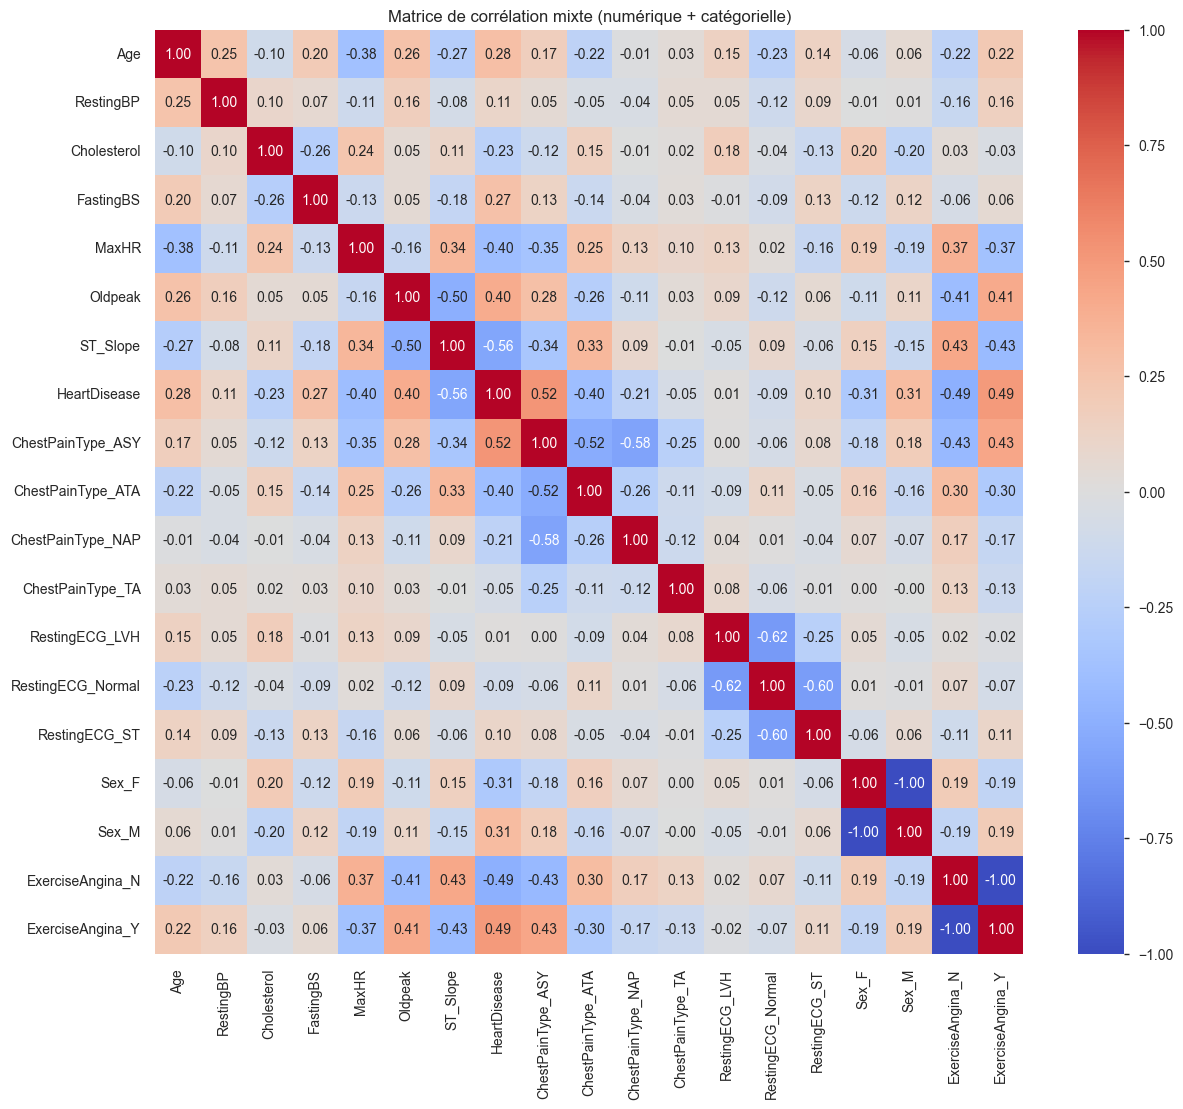

In [58]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

# Liste des variables catégorielles et numériques
cat_features = df.select_dtypes(include=['object']).columns.tolist()
num_features = df.select_dtypes(include=[np.number]).columns.tolist()

corr_matrix = pd.DataFrame(index=cat_features+num_features, columns=cat_features+num_features)

for var1 in corr_matrix.index:
    for var2 in corr_matrix.columns:
        if var1 in cat_features and var2 in cat_features:
            corr_matrix.loc[var1,var2] = cramers_v(df[var1], df[var2])
        elif var1 in num_features and var2 in num_features:
            corr_matrix.loc[var1,var2] = df[var1].corr(df[var2])
        else:
            # corr entre num et cat via Kendall's Tau sur codes cat
            if var1 in cat_features and var2 in num_features:
                corr_matrix.loc[var1,var2] = kendalltau(df[var1].astype('category').cat.codes, df[var2])[0]
            else:
                corr_matrix.loc[var1,var2] = kendalltau(df[var2].astype('category').cat.codes, df[var1])[0]

corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation mixte (numérique + catégorielle)")
plt.show()



In [60]:

# 3. NETTOYAGE ET PRÉPARATION DES DONNÉES

# Remplacement des NaN numériques par la médiane
imputer = SimpleImputer(strategy='median')
df[num_features] = imputer.fit_transform(df[num_features])

# Encodage One-Hot pour variables catégorielles sans ordre
one_hot_vars = ['ChestPainType', 'RestingECG', 'Sex', 'ExerciseAngina']
encoder = OneHotEncoder(sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df[one_hot_vars]), columns=encoder.get_feature_names_out(one_hot_vars))

# Encodage ordinal pour ST_Slope (Up < Flat < Down)
label_encoder = LabelEncoder()
df['ST_Slope_enc'] = label_encoder.fit_transform(df['ST_Slope'])

# Assemblage final du dataset
df_final = pd.concat([df.drop(columns=one_hot_vars + ['ST_Slope']), encoded_df, df['ST_Slope_enc']], axis=1)

# Normalisation des variables numériques (à refaire après concat)
num_features_final = [col for col in df_final.columns if df_final[col].dtype in [np.float64, np.int64] and col != 'HeartDisease']
scaler = StandardScaler()
df_final[num_features_final] = scaler.fit_transform(df_final[num_features_final])

print("Données prêtes à l'entraînement.")
display(df_final.head())

# %%
# 4. EXPÉRIMENTATION - TEST DES SOUS-ENSEMBLES DE VARIABLES POUR LE KNN

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

X = df_final.drop(columns=['HeartDisease'])
y = df_final['HeartDisease']

# Préparer plusieurs jeux de données basés sur la corrélation observée
features_sets = {
    'Top 5 corrélées': corr_matrix['HeartDisease'].abs().sort_values(ascending=False).index[1:6].tolist(),
    'Top 10 corrélées': corr_matrix['HeartDisease'].abs().sort_values(ascending=False).index[1:11].tolist(),
    'Toutes features': X.columns.tolist(),
}

results = []

for name, features in features_sets.items():
    X_sub = X[features]
    X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size=0.2, random_state=42, stratify=y)
    
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append((name, acc, rec, f1))
    
    print(f"Jeu : {name} — Accuracy: {acc:.3f}, Recall: {rec:.3f}, F1-score: {f1:.3f}")

# %%
# Affichage synthétique
results_df = pd.DataFrame(results, columns=['Jeu de variables', 'Accuracy', 'Recall', 'F1-score'])
display(results_df)

# %%
# Optionnel : Matrice de confusion pour le meilleur jeu (ici exemple Top 10)
best_features = features_sets['Top 10 corrélées']
X_train, X_test, y_train, y_test = train_test_split(X[best_features], y, test_size=0.2, random_state=42, stratify=y)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap='Blues')
plt.title("Matrice de confusion pour KNN - Top 10 features")
plt.show()


KeyError: "None of [Index(['ChestPainType', 'RestingECG', 'Sex', 'ExerciseAngina'], dtype='object')] are in the [columns]"